# McKinsey Analytics Online Hackathon - Insurance renewal - July 2018

In [ ]:
# importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

### Importing data

In [332]:
# loading the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### Data exploration & understanding

In [333]:
train.head(3)

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0


In [334]:
print("Shape of")
print("- train",train.shape)
print("- test", test.shape)

Shape of
- train (79853, 13)
- test (34224, 12)


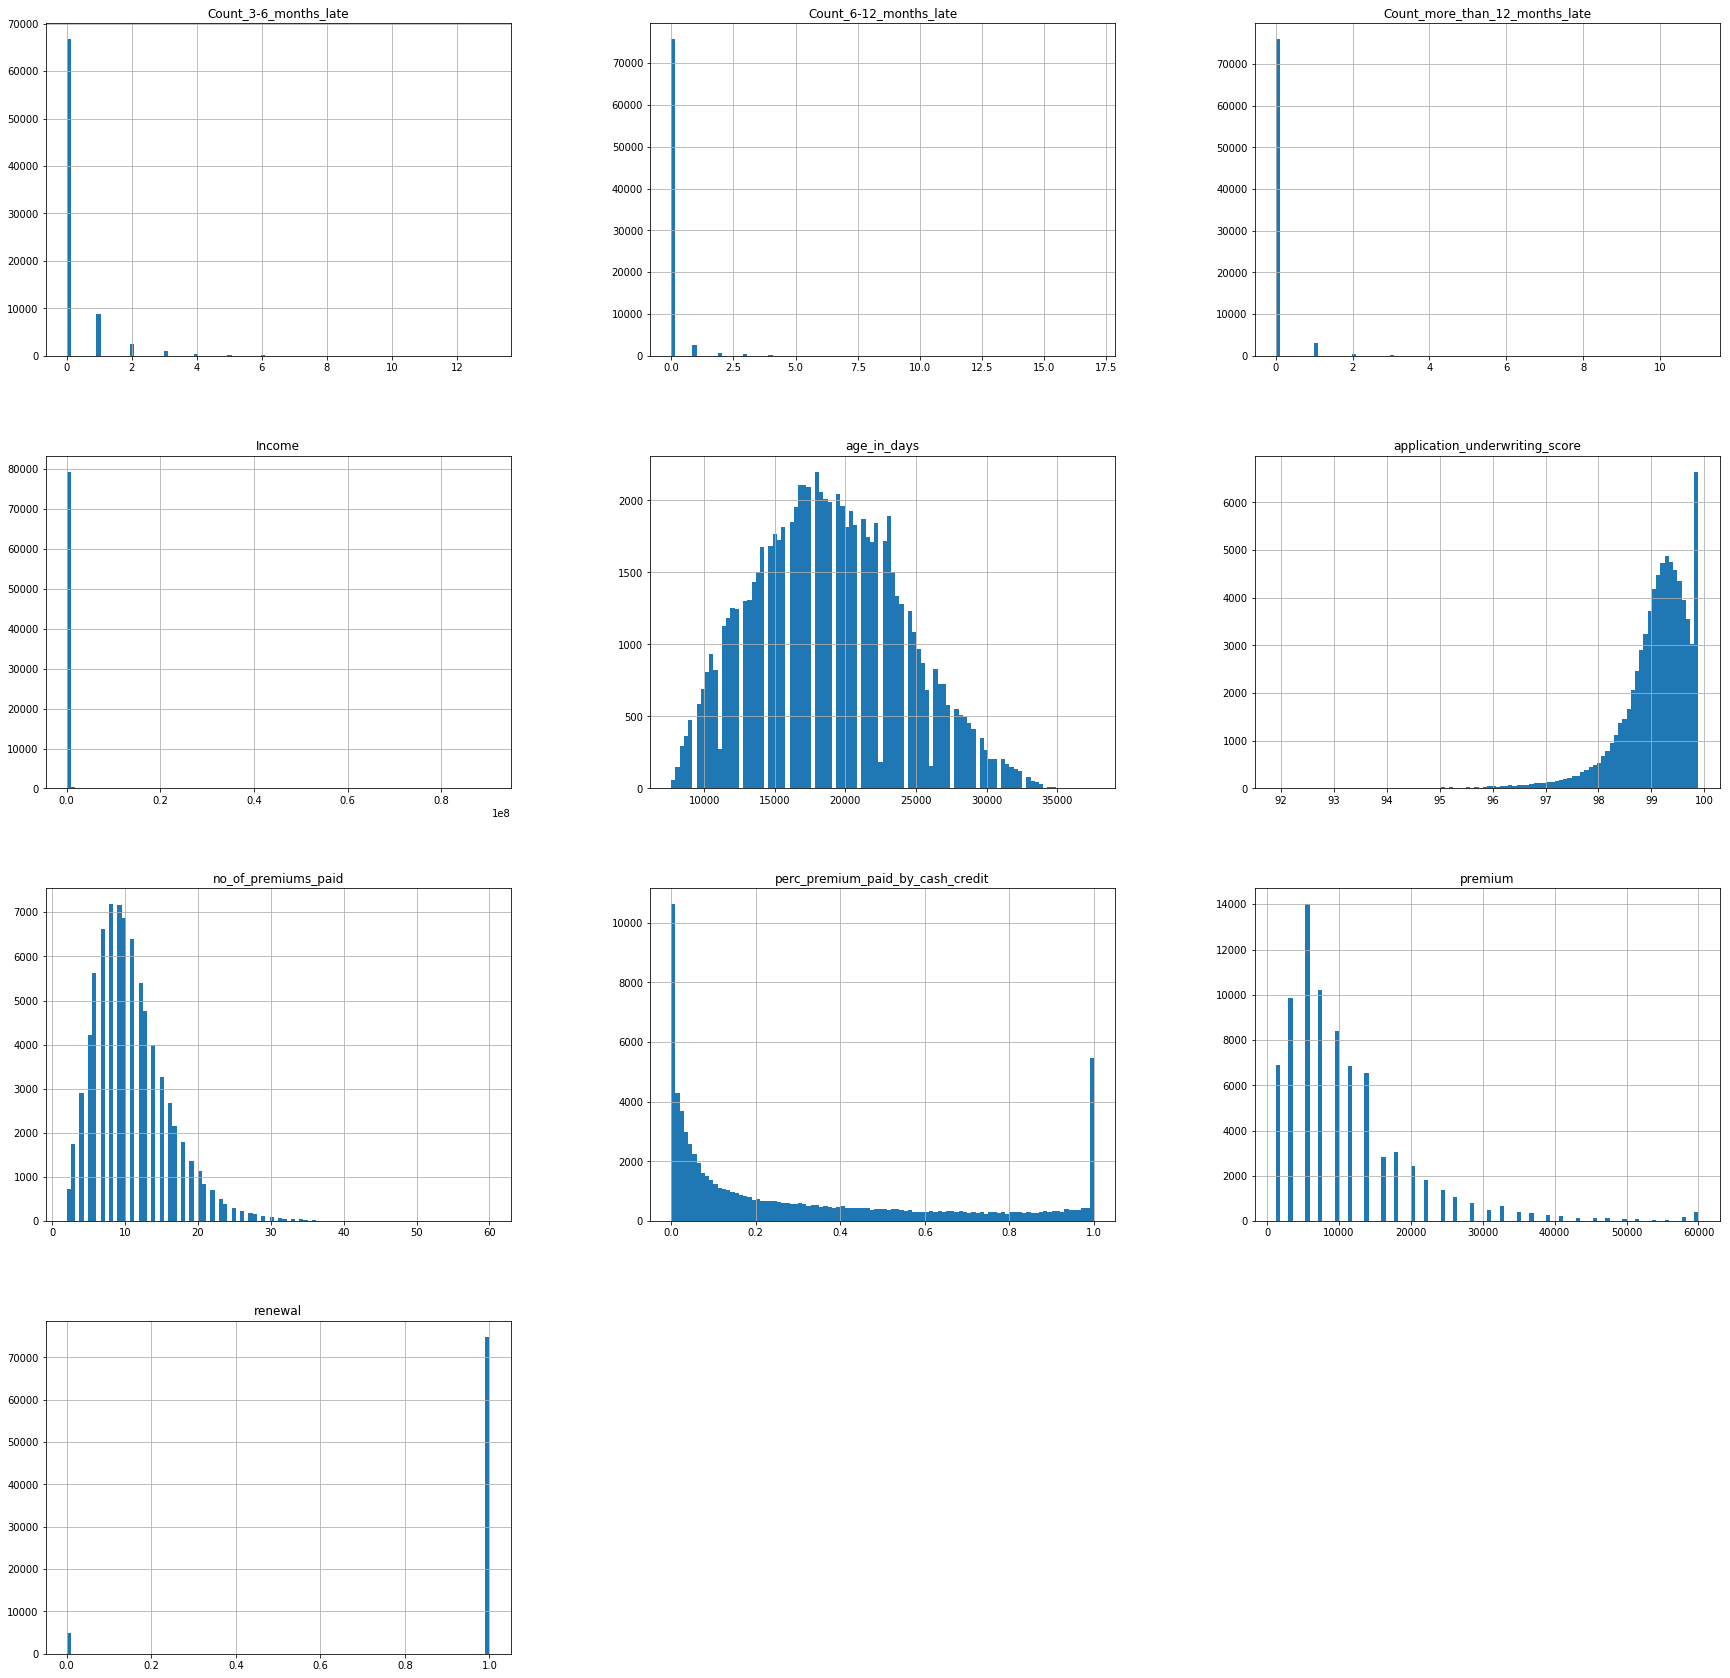

In [335]:
# plotting to get an indea of the distribution for each column
%matplotlib inline
train[['perc_premium_paid_by_cash_credit', 'age_in_days', 'Income', 'Count_3-6_months_late', 'Count_6-12_months_late',
       'Count_more_than_12_months_late', 'application_underwriting_score', 'no_of_premiums_paid', 'sourcing_channel',
       'residence_area_type','premium','renewal']].hist(figsize=(30, 30),  bins=100)
plt.show()


In [336]:
renewal_yes = np.count_nonzero(train['renewal'] == 1)
renewal_no = np.count_nonzero(train['renewal'] == 0)
print('% of renewal: ', round(((renewal_yes/79853)*100),3),'%')

% of renewal:  93.741 %


In [337]:
# obviously, 'sourcing_channel coundn't be plotted without transformation as an hist
channel_A = np.count_nonzero(train['sourcing_channel'] == 'A')
channel_B = np.count_nonzero(train['sourcing_channel'] == 'B')
channel_C = np.count_nonzero(train['sourcing_channel'] == 'C')
channel_D = np.count_nonzero(train['sourcing_channel'] == 'D')
channel_E = np.count_nonzero(train['sourcing_channel'] == 'E')
keys_channels = ['A', 'B', 'C', 'D', 'E']
value_channels = [channel_A, channel_B, channel_C, channel_D, channel_E]

d = {key:value for key, value in zip(keys_channels, value_channels)}
lists = sorted(d.items())
print('channels values: ', lists)
x, y = zip(*lists)

channels values:  [('A', 43134), ('B', 16512), ('C', 12039), ('D', 7559), ('E', 609)]


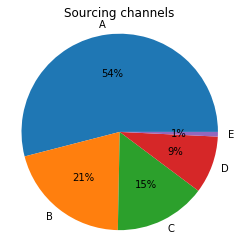

In [338]:
plt.pie(y, labels=x, autopct='%1.0f%%')
plt.axis("image")
plt.title('Sourcing channels', loc='center')
plt.show()

### Data preparation

In [339]:
# storing and removing id
train_id = train.id
test_id = test.id
train = train.drop("id", inplace = False, axis = 1)
test = test.drop("id", inplace = False, axis = 1)

In [340]:
# storing and removing train's label 'renewal'
train_renewal = train.renewal
train = train.drop("renewal", inplace = False, axis = 1)
y = train_renewal

In [341]:
print("Shape of")
print("- train",train.shape)
print("- test", test.shape)

Shape of
- train (79853, 11)
- test (34224, 11)


In [342]:
# Concatenate
features = pd.concat([train, test]).reset_index(drop=True)
print("features shape:", features.shape)

features shape: (114077, 11)


In [343]:
print("Overview of column types")
print('')
print(features.dtypes)

Overview of column types

perc_premium_paid_by_cash_credit    float64
age_in_days                           int64
Income                                int64
Count_3-6_months_late               float64
Count_6-12_months_late              float64
Count_more_than_12_months_late      float64
application_underwriting_score      float64
no_of_premiums_paid                   int64
sourcing_channel                     object
residence_area_type                  object
premium                               int64
dtype: object


### Feature engineering

#### Dealing with NAs

In [344]:
# chunk of code that Laurens used in the Kaggle House Prices competition
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values.")

                                   0        1
application_underwriting_score  4297  float64
Count_3-6_months_late            128  float64
Count_6-12_months_late           128  float64
Count_more_than_12_months_late   128  float64
There are 4 columns with missing values.


In [345]:
# filling missing values with the mode for the numbers of premimum late months ('Count...') 
features.update(features['Count_3-6_months_late'].fillna(features['Count_3-6_months_late'].mode()[0]))
features.update(features['Count_6-12_months_late'].fillna(features['Count_6-12_months_late'].mode()[0]))
features.update(features['Count_more_than_12_months_late'].fillna(features['Count_more_than_12_months_late'].mode()[0]))

In [346]:
# filling missing values with median for: 'application_underwriting_score' 
features.update(features['application_underwriting_score'].fillna(features['application_underwriting_score'].median()))

#### Creating some features

In [347]:
# creating a sum of premium late months
features['sum_months_late'] = (features['Count_3-6_months_late'] + features['Count_6-12_months_late'] + 
                                features['Count_more_than_12_months_late'])

In [348]:
list(set(features['sum_months_late']))

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0]

In [349]:
# replacing the 'None' values in 'sum_months_late'
features['sum_months_late'].replace(to_replace=['NoneNoneNone'], 
                                      value = 0,
                                      inplace=True)

In [350]:
features.head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,sum_months_late
0,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,0.0
1,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,0.0
2,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,6.0
3,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,0.0
4,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,0.0


#### Rescaling some numerical features

In [351]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features_to_rescale = ['age_in_days', 'Income', 'premium']

for i in features_to_rescale:
    features[i] = scaler.fit_transform(features[i].values.reshape(-1,1))

C:\Users\lramp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


#### Encoding categorical values

In [352]:
# label encoder should be preferred over One-Hot encoding, as one model is going to be Random Forest
from sklearn.preprocessing import LabelEncoder

features_to_encode = ['sourcing_channel', 'residence_area_type']


cols = features_to_encode
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(features[c].values)) 
    features[c] = lbl.transform(list(features[c].values))

In [353]:
# we have to split again the data between train and test
X = features.iloc[:len(train),:]
testing_features = features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)
print("Good, both dimensions are coherent.")

(79853, 12)
(34224, 12)
Good, both dimensions are coherent.


#### Dealing with outliers

In [354]:
from sklearn.neighbors import LocalOutlierFactor

In [355]:
detector = LocalOutlierFactor(n_neighbors=20, contamination=0.0001, n_jobs=3)
outliers_predictions = detector.fit_predict(X)

In [356]:
outliers = []
for index, value in enumerate(outliers_predictions):
     if value == -1:
        outliers.append(index)
print('number of outliers to remove:', len(outliers))

number of outliers to remove: 8


In [357]:
print(X.shape)
print(y.shape)

(79853, 12)
(79853,)


In [358]:
# removing them
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])
print(X.shape)
print(y.shape)

(79845, 12)
(79845,)


In [359]:
print(X.shape)
print(y.shape)

(79845, 12)
(79845,)


In [360]:
X.to_csv("X.csv",index = False)
y.to_csv("y.csv",index = False)

### Modelling - Random Forest Regression with StratifiedKFold

In [269]:
# importing libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [116]:
# create StratifiedKFold instance
skf = StratifiedKFold(5)

# Use randomizedsearchcv to find the best parameters
rf = RandomForestRegressor(criterion =  'mse', bootstrap = True)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = {'min_samples_split': [5, 10],
                                                 'n_estimators': [1000,1200],
                                                 'max_features': ['auto', 'sqrt'],
                                                 'max_depth': [30, 60, 90]}, 
                               cv = skf, verbose=10, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X, y.values.ravel()) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 95.4min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 102.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 115.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 124.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 153.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 158.2min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'min_samples_split': [5, 10], 'n_estimators': [1000, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [30, 60, 90]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [117]:
# retrieve the best estimator
rfr_tuned = rf_random.best_estimator_
rfr_tuned

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [118]:
# get cross validated score using best estimator
rfr_tuned_acc = cross_val_score(rfr_tuned, X, y.values.ravel(), cv = skf, scoring = 'neg_mean_squared_error', verbose = 5)

[CV]  ................................................................
[CV] .................... , score=-0.049231663414672396, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV] .................... , score=-0.049268857856810566, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


[CV] ..................... , score=-0.05012312514055788, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.1min remaining:    0.0s


[CV] ..................... , score=-0.04947736433026872, total= 1.4min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.5min remaining:    0.0s


[CV] ..................... , score=-0.05069657546892131, total= 1.4min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.9min finished


In [167]:
print("average cross validated negative MSE score:",np.mean(rfr_tuned_acc))

average cross validated negative MSE score: -0.04975951724224618


In [120]:
# exporting the model
from sklearn.externals import joblib
joblib.dump(rfr_tuned, "rfr2_tuned.pkl")

['rfr2_tuned.pkl']

In [121]:
# importing the model back
from sklearn.externals import joblib
rfr_tuned_imported = joblib.load("rfr2_tuned.pkl")

#### Prediction Random Forest

In [122]:
# fit data to model and predict using test data
rfr_tuned_imported.fit(X, y.values.ravel()) # or rf_tuned_imported.fit
prediction = rfr_tuned_imported.predict(testing_features) # same, _imported

In [123]:
#prediction = rf_tuned.fit(X, y.values.ravel()).predict(testing_features)
before_submission = pd.DataFrame()
before_submission['id'] = test_id
before_submission['renewal'] = prediction

before_submission.to_csv("Mck_Insurance_RFR2_submission.csv",index = False)

In [125]:
# we need 'premium' feature to calculate incentives
test['id'] = test_id
merged = pd.merge(before_submission, test[['premium','id']], how="left", on="id")
merged.head()

,id,renewal,premium
0,649,0.991514,3300
1,81136,0.979313,11700
2,70762,0.814951,11700
3,53935,0.994593,5400
4,15476,0.935507,9600


### Incentives imputation RF

In [126]:
# creating a range function that support float type
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [169]:
print('Maximum premium:',merged.premium.max())

Maximum premium: 60000


In [129]:
import operator
merged['incentives'] = ''

for row in range(len(merged['renewal'])):
    list_incentives = []
    for incentives in frange(0,4000,50): # after some trials, I realized 4k was clearly sufficient
        total_revenue = ( (((merged['renewal'][row]) +  ((merged['renewal'][row])*(20*(1-np.exp(-(10*(1-np.exp(-incentives /400)))/ 5))))) * merged['premium'][row] ) - incentives)
        #print(total_revenue)
        list_incentives.append(total_revenue)
    index, value = max(enumerate(list_incentives), key=operator.itemgetter(1))
    merged['incentives'][row] = index

C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [130]:
merged.head()

,id,renewal,premium,incentives
0,649,0.991514,3300,31
1,81136,0.979313,11700,40
2,70762,0.814951,11700,39
3,53935,0.994593,5400,35
4,15476,0.935507,9600,39


In [131]:
merged_final = merged.drop("premium", inplace = False, axis = 1)

In [132]:
merged_final.head()

,id,renewal,incentives
0,649,0.991514,31
1,81136,0.979313,40
2,70762,0.814951,39
3,53935,0.994593,35
4,15476,0.935507,39


In [134]:
merged_final.to_csv("Mck_Insurance_RFR2_submission.csv",index = False)

### Modelling - XGBoost with Bayesian Optimization (obj = 'reg:logistic')

In [409]:
from sklearn.cross_validation import cross_val_score as cv_s
from bayes_opt import BayesianOptimization as BayesOpt
import xgboost as xgb

# in the Cloud, use
#!pip install numpy scipy scikit-learn bayesian-optimization
#from bayes_opt import BayesianOptimization as BayesOpt
# link used to find the library http://philipperemy.github.io/visualization/

In [237]:
# Setting up the bayesian-optimization
# Comment out any parameter you don't want to test

def xgbcv(max_depth,  
          learning_rate, 
          n_estimators,
          min_child_weight,
          gamma,
          subsample,
          colsample_bytree,
          reg_alpha, 
          reg_lambda,
          silent=True):
    return cv_s(xgb.XGBRegressor(max_depth=int(max_depth),
                                 learning_rate=learning_rate,
                                 n_estimators=int(n_estimators),
                                 gamma=gamma,
                                 reg_alpha=reg_alpha,
                                 min_child_weight=min_child_weight,
                                 objective='reg:logistic'),
                    X,
                    labels,
                    "accuracy",
                    cv=4).mean() 

##Setting range of parameters for optimization
xgboostBO = BayesOpt(xgbcv,
                                 {
                                  'max_depth': (5,23),
                                  'learning_rate': (0.01, 0.2),
                                  'n_estimators': (200,600),
                                  'gamma': (0.01, 10),
                                  'min_child_weight': (1,40),
                                  'subsample': (0.2, 1),
                                  'colsample_bytree' :(0.2, 1),
                                  'reg_alpha':(0, 10),
                                  'reg_lambda':(0, 10)
                                  })

#### Chunk of code used to find best parameters in Google Cloud

In [ ]:
labels = y.values.ravel()
print ("Start Optimization of XGBoost Model")

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    xgboostBO.maximize(init_points=10,n_iter=110, xi=0.0,  acq="poi")

##### Among best parameters, there was:

 Step |   Time |      Value |   colsample_bytree |     gamma |   learning_rate |   max_depth |   min_child_weight |   n_estimators |   reg_alpha |   reg_lambda |   subsample | 
 
   
   41 | 01m47s |    0.93965 |             0.3456 |    8.1382 |          0.1845 |     10.4814 |            28.7466 |       431.5397 |      6.0434 |       4.9929 |      0.2763 | 
   
   54 | 01m46s |    0.93964 |             0.9813 |    8.6442 |          0.0978 |     13.6174 |            29.7687 |       435.8654 |      8.6909 |       5.9812 |      0.7315 | 
   
   52 | 01m48s |    0.93961 |             0.4859 |    9.4319 |          0.1161 |     11.0166 |            30.5838 |       441.3894 |      6.8601 |       2.7014 |      0.8760 | 
    
    
The 3rd (last one) scored the best among these 3 when submitting. So I decided to keep it as my best XGB parameters.

In [136]:
# best parameters LOG
best_param = {
    'colsample_bytree': 0.4859,
    'gamma': 9.4319,
    'learning_rate': 0.1161,
    'max_depth' : 11,
    'min_child_weight': 30.5838,
    #'n_estimators': 441,  #mentioned as num_boost_round in xgb.train 
    'reg_alpha': 6.8601,
    'reg_lambda': 2.7014,
    'subsample': 0.8760,
    'objective':'reg:logistic',
    'eval_metric': 'rmse',
    'seed' : 17 }

In [137]:
labels = y
train_dmatrix = xgb.DMatrix(X, label=labels, missing=np.nan)
print(X.shape)
print(labels.shape)

(79845, 12)
(79845,)


In [138]:
clf_XGB = xgb.train(best_param, dtrain=train_dmatrix, num_boost_round=441, maximize=False)

#### Prediction XGBoost

In [139]:
test_dmatrix = xgb.DMatrix(testing_features, missing=np.nan)
prediction2 = clf_XGB.predict(test_dmatrix)

In [140]:
prediction2

array([0.9919194 , 0.9854747 , 0.83245784, ..., 0.95306087, 0.7169293 ,
       0.95338094], dtype=float32)

In [141]:
#y_pred = LEncoder.inverse_transform(prediction2.astype(int))
df = pd.DataFrame({'id': test_id, 'renewal': prediction2}) #y_pred.ravel()
df.to_csv("Mck_Insurance_XGB_LOG3.2_submission.csv",index = False)

### Incentives imputation XGB

In [142]:
test['id'] = test_id
merged2 = pd.merge(df, test[['premium','id']], how="left", on="id")
merged2.head()

,id,renewal,premium
0,649,0.991919,3300
1,81136,0.985475,11700
2,70762,0.832458,11700
3,53935,0.978143,5400
4,15476,0.963172,9600


In [143]:
import operator
merged2['incentives'] = ''

for row in range(len(merged2['renewal'])):
    list_incentives = []
    for incentives in frange(0,4000,50): # after some trials, I realized 4k was clearly sufficient
        total_revenue = ( (((merged2['renewal'][row]) +  ((merged2['renewal'][row])*(20*(1-np.exp(-(10*(1-np.exp(-incentives /400)))/ 5))))) * merged2['premium'][row] ) - incentives)
        #print(total_revenue)
        list_incentives.append(total_revenue)
    index, value = max(enumerate(list_incentives), key=operator.itemgetter(1))
    merged2['incentives'][row] = index

C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [144]:
merged2.head()

,id,renewal,premium,incentives
0,649,0.991919,3300,31
1,81136,0.985475,11700,41
2,70762,0.832458,11700,39
3,53935,0.978143,5400,34
4,15476,0.963172,9600,39


In [145]:
merged2_final = merged2.drop("premium", inplace = False, axis = 1)

In [147]:
merged2_final.to_csv("Mck_Insurance_XGB_LOG3.2_final_submission.csv",index = False)

### Modelling - Catboost Regressor

In [492]:
from catboost import CatBoostRegressor

In [493]:
cbc = CatBoostRegressor(eval_metric = 'AUC')

In [494]:
cbc.fit(X, labels)

0:	total: 78.1ms	remaining: 1m 17s
1:	total: 156ms	remaining: 1m 17s
2:	total: 233ms	remaining: 1m 17s
3:	total: 316ms	remaining: 1m 18s
4:	total: 410ms	remaining: 1m 21s
5:	total: 532ms	remaining: 1m 28s
6:	total: 623ms	remaining: 1m 28s
7:	total: 744ms	remaining: 1m 32s
8:	total: 855ms	remaining: 1m 34s
9:	total: 970ms	remaining: 1m 36s
10:	total: 1.07s	remaining: 1m 36s
11:	total: 1.17s	remaining: 1m 36s
12:	total: 1.26s	remaining: 1m 35s
13:	total: 1.38s	remaining: 1m 37s
14:	total: 1.48s	remaining: 1m 37s
15:	total: 1.6s	remaining: 1m 38s
16:	total: 1.71s	remaining: 1m 39s
17:	total: 1.81s	remaining: 1m 38s
18:	total: 1.93s	remaining: 1m 39s
19:	total: 2.05s	remaining: 1m 40s
20:	total: 2.14s	remaining: 1m 39s
21:	total: 2.24s	remaining: 1m 39s
22:	total: 2.34s	remaining: 1m 39s
23:	total: 2.5s	remaining: 1m 41s
24:	total: 2.64s	remaining: 1m 42s
25:	total: 2.81s	remaining: 1m 45s
26:	total: 2.99s	remaining: 1m 47s
27:	total: 3.16s	remaining: 1m 49s
28:	total: 3.28s	remaining: 1m 

232:	total: 23.3s	remaining: 1m 16s
233:	total: 23.4s	remaining: 1m 16s
234:	total: 23.4s	remaining: 1m 16s
235:	total: 23.5s	remaining: 1m 16s
236:	total: 23.6s	remaining: 1m 16s
237:	total: 23.7s	remaining: 1m 15s
238:	total: 23.8s	remaining: 1m 15s
239:	total: 23.9s	remaining: 1m 15s
240:	total: 24s	remaining: 1m 15s
241:	total: 24.1s	remaining: 1m 15s
242:	total: 24.2s	remaining: 1m 15s
243:	total: 24.3s	remaining: 1m 15s
244:	total: 24.4s	remaining: 1m 15s
245:	total: 24.5s	remaining: 1m 14s
246:	total: 24.5s	remaining: 1m 14s
247:	total: 24.6s	remaining: 1m 14s
248:	total: 24.7s	remaining: 1m 14s
249:	total: 24.8s	remaining: 1m 14s
250:	total: 24.9s	remaining: 1m 14s
251:	total: 25s	remaining: 1m 14s
252:	total: 25.1s	remaining: 1m 14s
253:	total: 25.2s	remaining: 1m 13s
254:	total: 25.3s	remaining: 1m 13s
255:	total: 25.3s	remaining: 1m 13s
256:	total: 25.4s	remaining: 1m 13s
257:	total: 25.5s	remaining: 1m 13s
258:	total: 25.6s	remaining: 1m 13s
259:	total: 25.7s	remaining: 1m 

468:	total: 47.2s	remaining: 53.5s
469:	total: 47.3s	remaining: 53.3s
470:	total: 47.4s	remaining: 53.2s
471:	total: 47.5s	remaining: 53.1s
472:	total: 47.7s	remaining: 53.1s
473:	total: 47.8s	remaining: 53s
474:	total: 47.8s	remaining: 52.9s
475:	total: 47.9s	remaining: 52.8s
476:	total: 48s	remaining: 52.7s
477:	total: 48.1s	remaining: 52.5s
478:	total: 48.3s	remaining: 52.5s
479:	total: 48.4s	remaining: 52.4s
480:	total: 48.5s	remaining: 52.3s
481:	total: 48.6s	remaining: 52.2s
482:	total: 48.7s	remaining: 52.2s
483:	total: 48.9s	remaining: 52.1s
484:	total: 49s	remaining: 52s
485:	total: 49.1s	remaining: 51.9s
486:	total: 49.2s	remaining: 51.8s
487:	total: 49.3s	remaining: 51.7s
488:	total: 49.3s	remaining: 51.6s
489:	total: 49.5s	remaining: 51.5s
490:	total: 49.6s	remaining: 51.4s
491:	total: 49.7s	remaining: 51.3s
492:	total: 49.8s	remaining: 51.2s
493:	total: 49.9s	remaining: 51.1s
494:	total: 50s	remaining: 51s
495:	total: 50.2s	remaining: 51s
496:	total: 50.3s	remaining: 50.9s

706:	total: 1m 11s	remaining: 29.8s
707:	total: 1m 11s	remaining: 29.7s
708:	total: 1m 12s	remaining: 29.6s
709:	total: 1m 12s	remaining: 29.5s
710:	total: 1m 12s	remaining: 29.4s
711:	total: 1m 12s	remaining: 29.3s
712:	total: 1m 12s	remaining: 29.2s
713:	total: 1m 12s	remaining: 29.1s
714:	total: 1m 12s	remaining: 29s
715:	total: 1m 12s	remaining: 28.9s
716:	total: 1m 12s	remaining: 28.8s
717:	total: 1m 12s	remaining: 28.6s
718:	total: 1m 13s	remaining: 28.5s
719:	total: 1m 13s	remaining: 28.4s
720:	total: 1m 13s	remaining: 28.3s
721:	total: 1m 13s	remaining: 28.2s
722:	total: 1m 13s	remaining: 28.1s
723:	total: 1m 13s	remaining: 28s
724:	total: 1m 13s	remaining: 27.9s
725:	total: 1m 13s	remaining: 27.8s
726:	total: 1m 13s	remaining: 27.7s
727:	total: 1m 13s	remaining: 27.6s
728:	total: 1m 13s	remaining: 27.5s
729:	total: 1m 14s	remaining: 27.4s
730:	total: 1m 14s	remaining: 27.3s
731:	total: 1m 14s	remaining: 27.2s
732:	total: 1m 14s	remaining: 27.1s
733:	total: 1m 14s	remaining: 27

937:	total: 1m 34s	remaining: 6.26s
938:	total: 1m 34s	remaining: 6.16s
939:	total: 1m 34s	remaining: 6.05s
940:	total: 1m 34s	remaining: 5.95s
941:	total: 1m 35s	remaining: 5.85s
942:	total: 1m 35s	remaining: 5.75s
943:	total: 1m 35s	remaining: 5.65s
944:	total: 1m 35s	remaining: 5.55s
945:	total: 1m 35s	remaining: 5.45s
946:	total: 1m 35s	remaining: 5.35s
947:	total: 1m 35s	remaining: 5.25s
948:	total: 1m 35s	remaining: 5.14s
949:	total: 1m 35s	remaining: 5.04s
950:	total: 1m 35s	remaining: 4.94s
951:	total: 1m 36s	remaining: 4.84s
952:	total: 1m 36s	remaining: 4.74s
953:	total: 1m 36s	remaining: 4.64s
954:	total: 1m 36s	remaining: 4.54s
955:	total: 1m 36s	remaining: 4.44s
956:	total: 1m 36s	remaining: 4.34s
957:	total: 1m 36s	remaining: 4.24s
958:	total: 1m 36s	remaining: 4.13s
959:	total: 1m 36s	remaining: 4.03s
960:	total: 1m 36s	remaining: 3.93s
961:	total: 1m 36s	remaining: 3.83s
962:	total: 1m 37s	remaining: 3.73s
963:	total: 1m 37s	remaining: 3.63s
964:	total: 1m 37s	remaining

In [495]:
prediction_3 = cbc.predict(testing_features)

In [496]:
cbc_submission = pd.DataFrame()
cbc_submission ['id'] = test_id
cbc_submission ['renewal'] = prediction_3

cbc_submission.to_csv("Mck_Insurance_Catboost_AUC_submission.csv",index = False)

In [497]:
# we need 'premium' feature to calculate incentives
test['id'] = test_id
cbc_submission = pd.merge(cbc_submission, test[['premium','id']], how="left", on="id")
cbc_submission.head()

,id,renewal,premium
0,649,0.995,3300
1,81136,0.986,11700
2,70762,0.769,11700
3,53935,0.983,5400
4,15476,0.958,9600


### Incentives imputation Catboost

In [395]:
# creating a range function that support float type
def frange(start, stop, step):
    i = start
    while i < stop:
        yield i
        i += step

In [396]:
print('Maximum premium:',merged.premium.max())

Maximum premium: 60000


In [397]:
import operator
cbc_submission['incentives'] = ''

for row in range(len(cbc_submission['renewal'])):
    list_incentives = []
    for incentives in frange(0,4000,50): # after some trials, I realized 4k was clearly sufficient
        total_revenue = ( (((cbc_submission['renewal'][row]) +  ((cbc_submission['renewal'][row])*(20*(1-np.exp(-(10*(1-np.exp(-incentives /400)))/ 5))))) * cbc_submission['premium'][row] ) - incentives)
        #print(total_revenue)
        list_incentives.append(total_revenue)
    index, value = max(enumerate(list_incentives), key=operator.itemgetter(1))
    cbc_submission['incentives'][row] = index

C:\Users\lramp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [398]:
cbc_submission.head()

,id,renewal,premium,incentives
0,649,0.994780,3300,31
1,81136,0.987059,11700,41
2,70762,0.762181,11700,38
3,53935,0.983039,5400,34
4,15476,0.961396,9600,39


In [399]:
cbc_submission = cbc_submission.drop("premium", inplace = False, axis = 1)

In [400]:
cbc_submission.head()

,id,renewal,incentives
0,649,0.994780,31
1,81136,0.987059,41
2,70762,0.762181,38
3,53935,0.983039,34
4,15476,0.961396,39


In [401]:
cbc_submission.to_csv("Mck_Insurance_Catboost_AUC_submission.csv",index = False)

I also tried to run Catboost with eval_metric = 'RMSE' but it wasn't as good as 'AUC'.

##### I then used soft voting classifiers to try to predict better renewals values. I was getting good results, but nothing was as good as the XGX Regression in the leaderboard.

##### I also discovered that I had a better score by setting the same incentive for every client... This was due to the scoring system of the competition and to the fact that these values were normalized afterwards.

### Leaderboard

5052 people registered to this McKinsey online hackathon, but only 926 people submitted a solution file.

Some may have forgotten to participate to the competition, and probably some others couldn't do it.

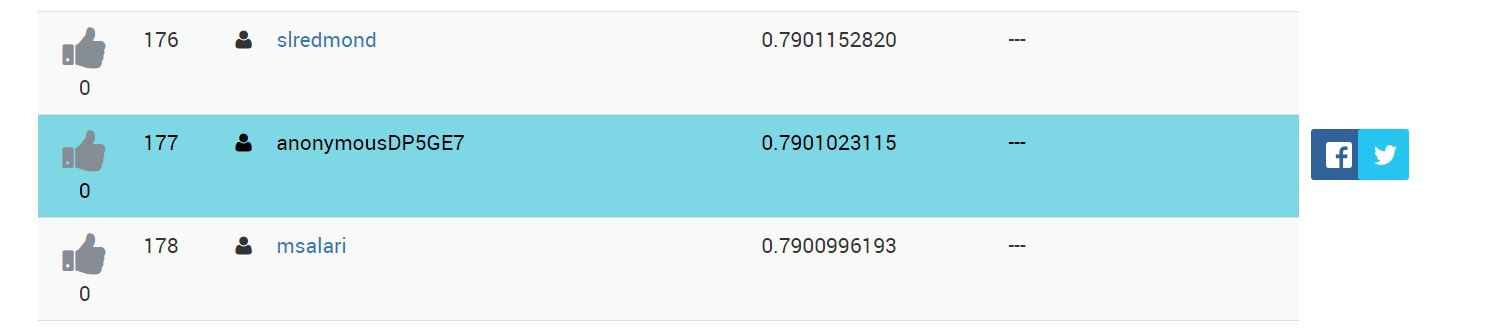

In [5]:
from IPython.display import Image
Image(filename='leaderboard-mck-insurance.jpg',width="800")

So I ranked 177 out of the 926 subimissions in the private (= final) leaderboard.

In the public one, I was around the 110th position.